# Fisherfaces

## Librerias

In [14]:
%matplotlib inline

import os
import cv2
import glob
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Carga de datos

In [15]:
# --- CONFIGURACIÓN ---
IMG_SIZE = (100, 100)
CLASES_MAP = {
    "joy": 0, "joyful": 0,
    "neutral": 1,
    "distraction": 2, "distracted": 2,
    "fatigue": 3, "fatigued": 3,
    "confusion": 4, "confused": 4
}

# 1. Cargar el detector desde el archivo local
cascade_path = 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)

# Verificación inmediata
if face_cascade.empty():
    print(f"ERROR: Archivo no encontrado en '{cascade_path}'.")
else:
    print("Detector cargado correctamente desde archivo local.")

def detectar_y_recortar(img):
    """ Detecta rostro, recorta y devuelve. Si falla, devuelve original. """
    if face_cascade.empty(): return img
    
    # Haar funciona mejor en escala de grises
    rostros = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(rostros) > 0:
        # Tomar el rostro más grande (area = w * h)
        x, y, w, h = max(rostros, key=lambda b: b[2] * b[3])
        return img[y:y+h, x:x+w]
    return img

def cargar_datos_fisher_mejorado(ruta_split):
    X = []
    y = []
    print(f"Procesando: {ruta_split}")
    
    if not os.path.exists(ruta_split):
        print(f"La ruta no existe: {ruta_split}")
        return np.array([]), np.array([])

    carpetas_emocion = os.listdir(ruta_split)
    
    for nombre_carpeta in carpetas_emocion:
        nombre_lower = nombre_carpeta.lower()
        if nombre_lower in CLASES_MAP:
            label = CLASES_MAP[nombre_lower]
            ruta_emocion = os.path.join(ruta_split, nombre_carpeta)
            
            # Recorrer archivos
            for archivo in os.listdir(ruta_emocion):
                ruta_img = os.path.join(ruta_emocion, archivo)
                try:
                    # Leer en gris
                    img = cv2.imread(ruta_img, 0)
                    if img is not None:
                        # Detectar -> Recortar -> Resize
                        img_face = detectar_y_recortar(img)
                        img_resized = cv2.resize(img_face, IMG_SIZE)
                        
                        X.append(img_resized.flatten())
                        y.append(label)
                except Exception as e:
                    pass # Ignorar imágenes corruptas

    return np.array(X), np.array(y)

# --- EJECUCIÓN ---
if not face_cascade.empty():
    base_path = "Synthetic_DB_CAS" # Verifica que esta ruta sea correcta
    
    print("--- Recargando TRAIN ---")
    X_train, y_train = cargar_datos_fisher_mejorado(os.path.join(base_path, "train"))
    
    print("--- Recargando VAL ---")
    X_val, y_val = cargar_datos_fisher_mejorado(os.path.join(base_path, "val"))
    
    print("--- Recargando TEST ---")
    X_test, y_test = cargar_datos_fisher_mejorado(os.path.join(base_path, "test"))
    
    print(f"\nDimensiones finales Train: {X_train.shape}")

Detector cargado correctamente desde archivo local.
--- Recargando TRAIN ---
Procesando: Synthetic_DB_CAS\train
--- Recargando VAL ---
Procesando: Synthetic_DB_CAS\val
--- Recargando TEST ---
Procesando: Synthetic_DB_CAS\test

Dimensiones finales Train: (424, 10000)


## Preparación de datos

In [16]:
print("--- Preparando Datos ---")
# Concatenamos las filas (axis=0) de Train y Val
X_full_train = np.concatenate((X_train, X_val), axis=0)
y_full_train = np.concatenate((y_train, y_val), axis=0)

print(f"Set de Entrenamiento Completo (Train+Val): {X_full_train.shape}")
print(f"Set de Prueba (Test): {X_test.shape}")


--- Preparando Datos ---
Set de Entrenamiento Completo (Train+Val): (514, 10000)
Set de Prueba (Test): (92, 10000)


## Estandarizar

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_full_train)
X_test_scaled = scaler.transform(X_test)

## PCA

In [18]:
# Usamos .95 para conservar el 95% de la varianza original y reducir ruido
pca = PCA(n_components=0.95, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Dimensiones tras PCA: {X_train_pca.shape[1]} componentes principales (de 10,000 originales)")


Dimensiones tras PCA: 148 componentes principales (de 10,000 originales)


## LDA

In [19]:
lda = LDA()
lda.fit(X_train_pca, y_full_train)
print("Modelo LDA entrenado exitosamente.")

Modelo LDA entrenado exitosamente.


In [20]:
sns.set_style("whitegrid")
nombres_clases = ["Joy", "Neutral", "Distraction", "Fatigue", "Confusion"]

# --- VISUALIZACIÓN 1: Muestras de Entrada ---
def plot_samples(X, y, n_samples=5):
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    for i in range(n_samples):
        # Tomamos un índice aleatorio
        idx = np.random.randint(0, len(X))
        
        img = X[idx].reshape(100, 100)
        label = nombres_clases[y[idx]]
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Clase: {label}")
        axes[i].axis('off')
    plt.suptitle("Ejemplos de entrada (Preprocesados)", fontsize=16)
    plt.show()

# --- VISUALIZACIÓN 2: El "Rostro Promedio" y los "Eigenfaces" ---
def plot_eigenfaces(pca_model):
    fig, axes = plt.subplots(1, 6, figsize=(18, 4))
    
    # 1. El rostro promedio (Mean Face)
    mean_face = pca_model.mean_.reshape(100, 100)
    axes[0].imshow(mean_face, cmap='gray')
    axes[0].set_title("Rostro Promedio\n(Mean Face)")
    axes[0].axis('off')
    
    # 2. Los primeros 5 componentes principales (Eigenfaces)
    for i in range(5):
        eigenface = pca_model.components_[i].reshape(100, 100)
        axes[i+1].imshow(eigenface, cmap='viridis') # Viridis ayuda a ver contrastes
        axes[i+1].set_title(f"Eigenface #{i+1}")
        axes[i+1].axis('off')
        
    plt.suptitle("Interior del PCA: Rostro Promedio y Componentes Principales", fontsize=16)
    plt.show()

# --- VISUALIZACIÓN 3: Proyección en Espacio LDA (2D) ---
def plot_lda_space(lda_model, X_pca, y_true):
    X_lda = lda_model.transform(X_pca)
    
    plt.figure(figsize=(10, 8))
    
    # Usamos scatterplot para ver la agrupación
    # Solo podemos graficar 2 dimensiones en pantalla plana (LD1 vs LD2)
    sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=[nombres_clases[i] for i in y_true], 
                    palette="deep", s=60, alpha=0.7)
    
    plt.title("Proyección de Fisher (LDA): Separación de Clases", fontsize=16)
    plt.xlabel("Primer Discriminante Lineal (LD1)")
    plt.ylabel("Segundo Discriminante Lineal (LD2)")
    plt.legend(title="Emoción")
    plt.show()

Generando gráficas del proceso...


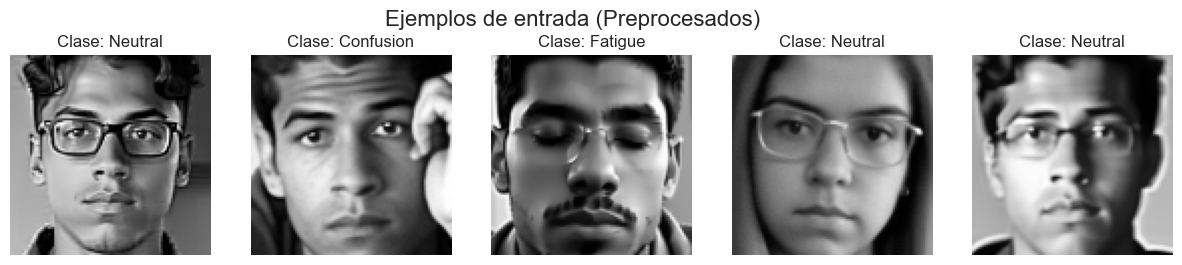

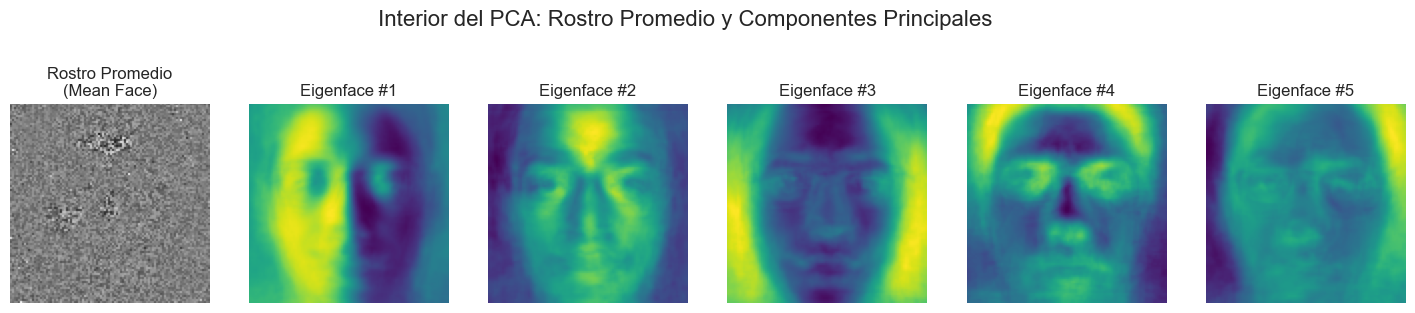

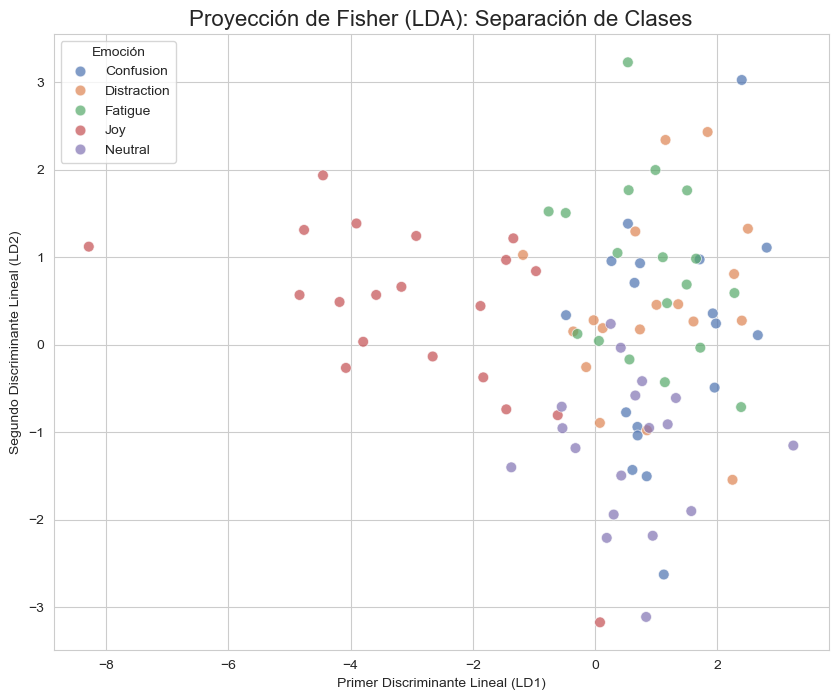

In [21]:
print("Generando gráficas del proceso...")

# 1. Ver ejemplos de datos
plot_samples(X_full_train, y_full_train)

# 2. Ver qué aprendió el PCA (Eigenfaces)
plot_eigenfaces(pca)

# 3. Ver cómo separa los grupos el LDA
plot_lda_space(lda, X_test_pca, y_test)

In [22]:
print(f"Número total de Eigenfaces encontradas: {pca.n_components_}")

Número total de Eigenfaces encontradas: 148


Generando promedios por clase...


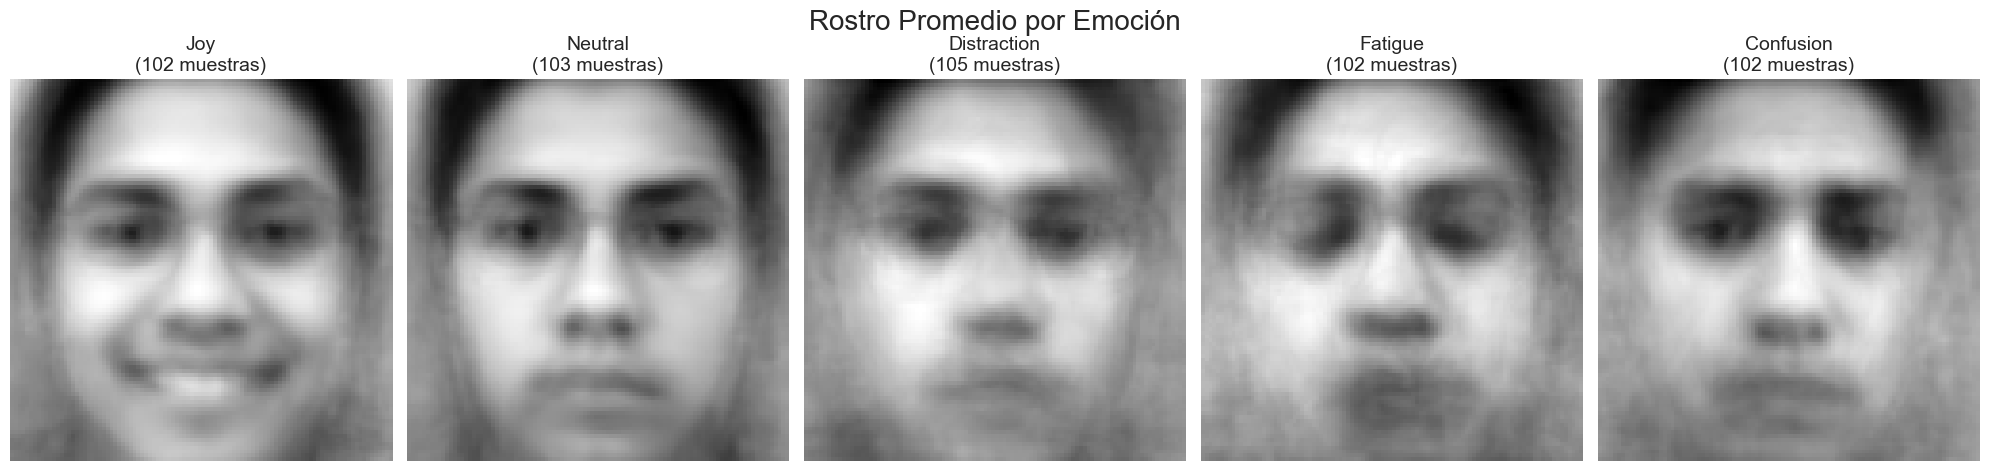

In [23]:
nombres_clases = ["Joy", "Neutral", "Distraction", "Fatigue", "Confusion"]

def visualizar_rostros_promedio(X, y):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    
    print("Generando promedios por clase...")
    
    for i in range(5):
        #Filtramos todas las imágenes que pertenecen a la clase 'i'
        indices_clase = np.where(y == i)[0]
        imagenes_clase = X[indices_clase]
        
        if len(imagenes_clase) > 0:
            #Calculamos el promedio a lo largo del eje 0
            imagen_promedio = np.mean(imagenes_clase, axis=0)
            
            img_visual = imagen_promedio.reshape(100, 100)
            
            axes[i].imshow(img_visual, cmap='gray')
            axes[i].set_title(f"{nombres_clases[i]}\n({len(imagenes_clase)} muestras)", fontsize=14)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, "Sin datos", ha='center')
            axes[i].axis('off')

    plt.suptitle("Rostro Promedio por Emoción", fontsize=20)
    plt.tight_layout()
    plt.show()

visualizar_rostros_promedio(X_full_train, y_full_train)

## Evaluación del test sintético

In [24]:
y_pred = lda.predict(X_test_pca)

# Métricas Globales
acc = accuracy_score(y_test, y_pred)
print(f"ACCURACY GLOBAL: {acc:.4f}")

# Reporte detallado por clase (Precision, Recall, F1)
nombres_clases = ["Joy", "Neutral", "Distraction", "Fatigue", "Confusion"]
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=nombres_clases))

ACCURACY GLOBAL: 0.5978

Reporte de Clasificación:
              precision    recall  f1-score   support

         Joy       1.00      0.80      0.89        20
     Neutral       0.54      0.72      0.62        18
 Distraction       0.52      0.61      0.56        18
     Fatigue       0.50      0.33      0.40        18
   Confusion       0.47      0.50      0.49        18

    accuracy                           0.60        92
   macro avg       0.61      0.59      0.59        92
weighted avg       0.62      0.60      0.60        92



### Matriz de confusión

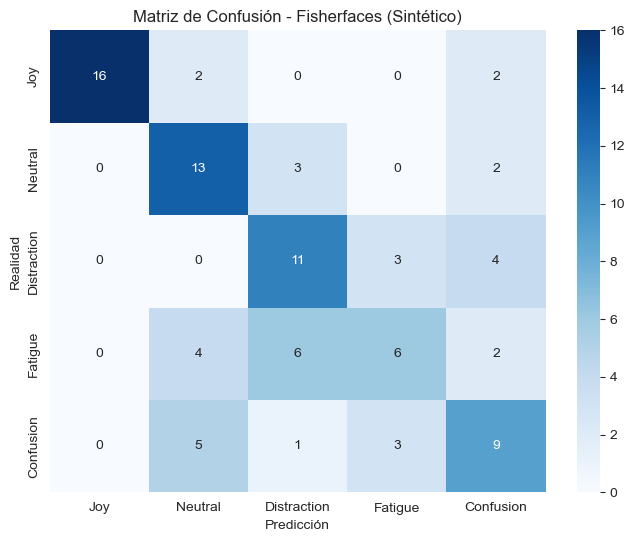

In [25]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=nombres_clases, yticklabels=nombres_clases)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Fisherfaces (Sintético)')
plt.show()

## Evaluación Sintética Fisherfaces

Análisis de tus Resultados (Fisherfaces Mejorado)
1. Joy tiene una precisión: 1.00 (Perfecta)

Esto es muy positivo. Al recortar la cara, la característica de "dientes mostrándose" y "comisuras hacia arriba" se volvió matemáticamente inconfundible para el algoritmo LDA frente a las otras 4 emociones neutras.

2. Fatigue vs. Distraction

Solo acertó 6 veces.
Confundió 6 veces Fatiga con Distraction.
Confundió 4 veces Fatiga con Neutral.


El modelo presenta dificultades para distinguir la 'Fatiga'. Matemáticamente, un rostro cansado (párpados caídos) tiene una varianza de píxeles muy similar a un rostro distraído o neutral. A diferencia de 'Joy', la fatiga no introduce cambios geométricos drásticos de alto contraste, lo que dificulta la separación lineal que intenta Fisherfaces.

## Evalución capturas del equipo

### Carga de imagenes dados los clips

In [64]:
# --- CONFIGURACIÓN ---
# Ruta donde están tus videos actualmente

# [Aquí hay que cambiar para todos los mienmbros del equipo]
RUTA_ORIGEN = "Equipo/Daniel" 

# Ruta donde quieres que aparezcan las imágenes extraídas
RUTA_DESTINO = "Equipo/Daniel"

# Configuración de extracción
FRAMES_POR_SEGUNDO = 3
SUJETO_ID = "S01"  # Identificador para el nombre del archivo

# Extensiones de video a buscar
# Revisar que el video sea compatible con OpenCV
EXTENSIONES = ['*.mp4', '*.mov', '*.avi', '*.mkv']

def procesar_videos_masivo():
    # Crear carpeta destino si no existe
    if not os.path.exists(RUTA_DESTINO):
        os.makedirs(RUTA_DESTINO)
        print(f"Carpeta creada: {RUTA_DESTINO}")

    # Recorrer cada carpeta de emoción (joy, neutral, etc.)
    carpetas_emocion = [d for d in os.listdir(RUTA_ORIGEN) if os.path.isdir(os.path.join(RUTA_ORIGEN, d))]
    
    total_imagenes = 0
    
    for emocion in carpetas_emocion:
        ruta_emocion_origen = os.path.join(RUTA_ORIGEN, emocion)
        ruta_emocion_destino = os.path.join(RUTA_DESTINO, emocion)
        
        # Crear subcarpeta de emoción en el destino
        if not os.path.exists(ruta_emocion_destino):
            os.makedirs(ruta_emocion_destino)
        
        # Buscar videos dentro de esta carpeta
        archivos_video = []
        for ext in EXTENSIONES:
            archivos_video.extend(glob.glob(os.path.join(ruta_emocion_origen, ext)))
            
        print(f"\nProcesando '{emocion}': {len(archivos_video)} videos encontrados.")
        
        for i, video_path in enumerate(archivos_video):
            nombre_video = os.path.basename(video_path)
            # Usamos el índice 'i' como ID del clip (C01, C02...)
            clip_id = f"C{str(i+1).zfill(2)}" 
            
            # --- Lógica de Extracción ---
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error leyendo: {nombre_video}")
                continue
                
            fps_video = cap.get(cv2.CAP_PROP_FPS)
            # Calcular 'step': cada cuántos frames reales capturamos uno
            step = int(fps_video / FRAMES_POR_SEGUNDO)
            if step < 1: step = 1
            
            frame_count = 0
            guardados_clip = 0
            
            while True:
                ret, frame = cap.read()
                if not ret: break
                
                if frame_count % step == 0:
                    # Nombre formato: Sujeto_Clip_Frame_Label.png
                    # Ejemplo: Daniel_C01_f0032_joy.png
                    nombre_img = f"{SUJETO_ID}_C{clip_id}_f{guardados_clip}_{emocion}.png"
                    ruta_final = os.path.join(ruta_emocion_destino, nombre_img)
                    
                    cv2.imwrite(ruta_final, frame)
                    guardados_clip += 1
                    total_imagenes += 1
                
                frame_count += 1
            
            cap.release()
            print(f"{nombre_video} -> {guardados_clip} imágenes extraídas.")

    print(f"\nPROCESO TERMINADO. Total de imágenes generadas: {total_imagenes}")
    print(f"Ubicación: {RUTA_DESTINO}")

# Ejecutar
procesar_videos_masivo()


Procesando 'confused': 1 videos encontrados.
confused.mp4 -> 16 imágenes extraídas.

Procesando 'distracted': 1 videos encontrados.
distracted.mp4 -> 16 imágenes extraídas.

Procesando 'fatigued': 1 videos encontrados.
fatigued.mp4 -> 22 imágenes extraídas.

Procesando 'joyful': 1 videos encontrados.
joyful.mp4 -> 16 imágenes extraídas.

Procesando 'neutral': 1 videos encontrados.
neutral.mp4 -> 13 imágenes extraídas.

PROCESO TERMINADO. Total de imágenes generadas: 83
Ubicación: Equipo/Daniel


### Despliegue de muestras

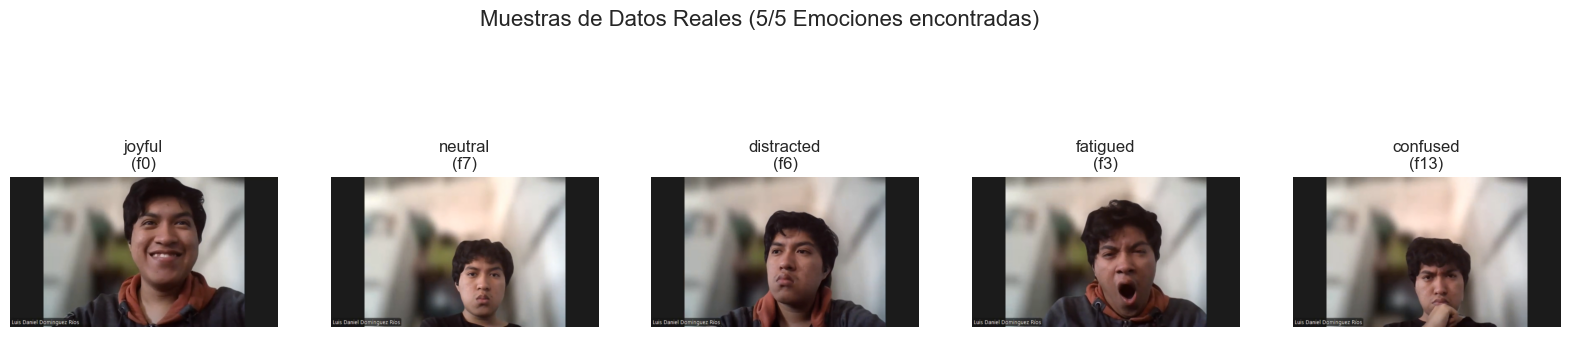

In [68]:
RUTA_DESTINO = "Equipo/Daniel" 
CLASES = ["joyful", "neutral", "distracted", "fatigued", "confused"]

def mostrar_ejemplos_reales():
    plt.figure(figsize=(20, 5))
    encontrados = 0
    
    for i, emocion in enumerate(CLASES):
        ruta_carpeta = os.path.join(RUTA_DESTINO, emocion)
        
        if os.path.exists(ruta_carpeta):
            imagenes = [f for f in os.listdir(ruta_carpeta) if f.endswith(('.png', '.jpg'))]
            
            if len(imagenes) > 0:
                # Seleccionar una al azar
                img_nombre = random.choice(imagenes)
                img_path = os.path.join(ruta_carpeta, img_nombre)
                
                img = mpimg.imread(img_path)
                
                ax = plt.subplot(1, 5, i + 1)
                plt.imshow(img)
                plt.title(f"{emocion}\n({img_nombre.split('_')[2]})") # Muestra el frame
                plt.axis("off")
                encontrados += 1
            else:
                ax = plt.subplot(1, 5, i + 1)
                plt.text(0.5, 0.5, "Carpeta vacía", ha='center')
                plt.title(emocion)
                plt.axis("off")
        else:
            ax = plt.subplot(1, 5, i + 1)
            plt.text(0.5, 0.5, "No encontrada", ha='center')
            plt.title(emocion)
            plt.axis("off")

    plt.suptitle(f"Muestras de Datos Reales ({encontrados}/5 Emociones encontradas)", fontsize=16)
    plt.show()

mostrar_ejemplos_reales()

### Prueba del modelo

--- Cargando datos reales de: Equipo/Daniel ---
Procesando: Equipo/Daniel
Se cargaron 83 imágenes reales.
Se cargaron 83 imágenes reales.
Aplicando transformaciones (Scaler -> PCA)...
Evaluando modelo Fisherfaces en datos reales...

ACCURACY EN DATOS REALES: 0.7470

Reporte de Clasificación (Real):
              precision    recall  f1-score   support

         Joy       1.00      0.88      0.93        16
     Neutral       0.00      0.00      0.00        13
 Distraction       0.55      1.00      0.71        16
     Fatigue       0.89      0.73      0.80        22
   Confusion       0.73      1.00      0.84        16

    accuracy                           0.75        83
   macro avg       0.63      0.72      0.66        83
weighted avg       0.67      0.75      0.69        83



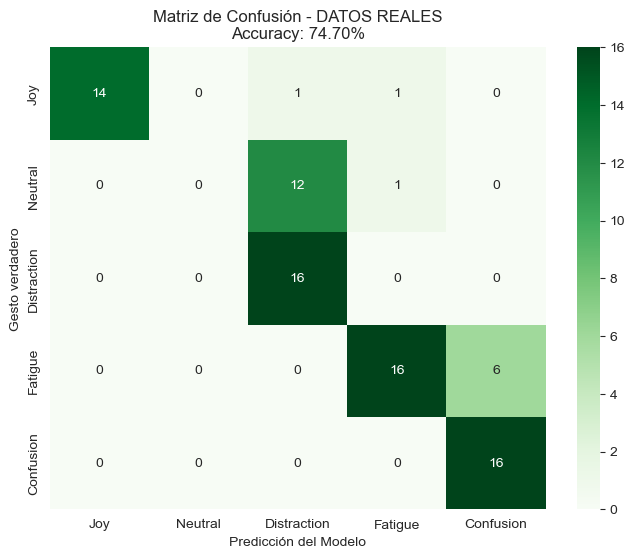

In [71]:
# --- 1. CARGAR DATOS REALES ---
# Usamos la misma lógica de "detectar -> recortar -> 100x100"
RUTA_REAL = "Equipo/Daniel" 

print(f"--- Cargando datos reales de: {RUTA_REAL} ---")
# Reutilizamos la función 'cargar_datos_fisher_mejorado' que ya creamos
X_real, y_real = cargar_datos_fisher_mejorado(RUTA_REAL)

if len(X_real) == 0:
    print("ERROR: No se cargaron imágenes. Verifica la ruta.")
else:
    print(f"Se cargaron {len(X_real)} imágenes reales.")
    print(f"Se cargaron {len(X_real)} imágenes reales.")

    # --- 2. PREPROCESAMIENTO (CRÍTICO) ---
    print("Aplicando transformaciones (Scaler -> PCA)...")
    
    # a) Estandarizar con la media/varianza del dataset sintético
    X_real_scaled = scaler.transform(X_real)
    
    # b) Proyectar al espacio de Eigenfaces (PCA) sintético
    X_real_pca = pca.transform(X_real_scaled)

    # --- 3. PREDICCIÓN Y EVALUACIÓN ---
    print("Evaluando modelo Fisherfaces en datos reales...")
    y_pred_real = lda.predict(X_real_pca)

    # --- 4. RESULTADOS ---
    acc_real = accuracy_score(y_real, y_pred_real)
    print(f"\nACCURACY EN DATOS REALES: {acc_real:.4f}")
    
    print("\nReporte de Clasificación (Real):")
    nombres_clases = ["Joy", "Neutral", "Distraction", "Fatigue", "Confusion"]
    print(classification_report(y_real, y_pred_real, target_names=nombres_clases, zero_division=0))

    # Matriz de Confusión
    cm_real = confusion_matrix(y_real, y_pred_real)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_real, annot=True, fmt='d', cmap='Greens', 
                xticklabels=nombres_clases, yticklabels=nombres_clases)
    
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Gesto verdadero')
    plt.title(f'Matriz de Confusión - DATOS REALES\nAccuracy: {acc_real:.2%}')
    plt.show()

Existen pocas diferencias para la diferenciación de Neutral.

# MobileNet

## Librerias adicionales

In [97]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping


## Recortar las imágenes

In [93]:
# Rutas
INPUT_DIR = "Equipo/Daniel" # Donde están tus fotos completas
OUTPUT_DIR = "Equipo_CROP/Daniel"      # Nueva carpeta para las caras recortadas

# Configuración
IMG_SIZE = (224, 224)
cascade_path = 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)

def recortar_dataset_real():
    if face_cascade.empty():
        print("❌ Error: No se encuentra el XML del detector.")
        return

    if not os.path.exists(INPUT_DIR):
        print(f"❌ Error: No encuentro la carpeta {INPUT_DIR}")
        return

    print(f"✂️ Iniciando recorte de rostros en: {INPUT_DIR}")
    
    # Recorrer cada emoción
    emociones = os.listdir(INPUT_DIR)
    total_procesadas = 0
    
    for emocion in emociones:
        ruta_origen = os.path.join(INPUT_DIR, emocion)
        ruta_destino = os.path.join(OUTPUT_DIR, emocion)
        
        if not os.path.isdir(ruta_origen): continue
        
        os.makedirs(ruta_destino, exist_ok=True)
        
        archivos = os.listdir(ruta_origen)
        count = 0
        
        for archivo in archivos:
            ruta_img = os.path.join(ruta_origen, archivo)
            
            # Leer imagen
            img = cv2.imread(ruta_img)
            if img is None: continue
            
            # Detectar rostro
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            rostros = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
            
            if len(rostros) > 0:
                # Tomar la cara más grande
                x, y, w, h = max(rostros, key=lambda b: b[2] * b[3])
                face = img[y:y+h, x:x+w]
                
                # Resize a 224x224
                face_resized = cv2.resize(face, IMG_SIZE)
                
                # Guardar en la nueva carpeta
                cv2.imwrite(os.path.join(ruta_destino, archivo), face_resized)
                count += 1
                total_procesadas += 1
            else:
                # Si no detecta cara, mejor no guardamos nada para no confundir al modelo
                pass
                
        print(f"   📂 {emocion}: {count} rostros recortados.")

    print(f"\n✅ Proceso terminado. Total imágenes listas: {total_procesadas}")
    print(f"📍 Usar ahora esta ruta para evaluación: {OUTPUT_DIR}")

# Ejecutar
recortar_dataset_real()

✂️ Iniciando recorte de rostros en: Equipo/Daniel
   📂 confused: 16 rostros recortados.
   📂 distracted: 16 rostros recortados.
   📂 fatigued: 22 rostros recortados.
   📂 joyful: 16 rostros recortados.
   📂 neutral: 13 rostros recortados.

✅ Proceso terminado. Total imágenes listas: 83
📍 Usar ahora esta ruta para evaluación: Equipo_CROP/Daniel


## Preparación de datos

In [94]:
# 1. Rutas
DIR_SINTETICO = "Synthetic_MobileNet_Ready"
DIR_REAL_CROP = "Equipo_CROP/Daniel" # ¡Usamos las RECORTADAS!

# 2. Parámetros Globales
BATCH_SIZE = 32
IMG_SHAPE = (224, 224)

# 3. Configurar Generadores
# [cite_start]Usamos preprocess_input para escalar de -1 a 1 (requisito de MobileNet) [cite: 69]
print("--- Configurando Generadores de Keras ---")
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generador de Entrenamiento
train_generator = datagen.flow_from_directory(
    os.path.join(DIR_SINTETICO, 'train'),
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Generador de Validación
val_generator = datagen.flow_from_directory(
    os.path.join(DIR_SINTETICO, 'val'),
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Generador de Prueba (Sintético)
test_generator = datagen.flow_from_directory(
    os.path.join(DIR_SINTETICO, 'test'),
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Generador de Datos Reales (Tu Rostro Recortado)
if os.path.exists(DIR_REAL_CROP):
    real_generator = datagen.flow_from_directory(
        DIR_REAL_CROP,
        target_size=IMG_SHAPE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # VERIFICACIÓN CRÍTICA DE ÍNDICES
    print(f"\nÍndices Sintético: {train_generator.class_indices}")
    print(f"Índices Real:      {real_generator.class_indices}")
    
    if train_generator.class_indices != real_generator.class_indices:
        print("⚠️ ALERTA: Los índices de clase no coinciden. Revisa el orden de carpetas.")
else:
    print(f"⚠️ No se encontró la carpeta de reales recortados: {DIR_REAL_CROP}")

--- Configurando Generadores de Keras ---
Found 424 images belonging to 5 classes.
Found 90 images belonging to 5 classes.
Found 92 images belonging to 5 classes.
Found 83 images belonging to 5 classes.

Índices Sintético: {'confused': 0, 'distracted': 1, 'fatigued': 2, 'joyful': 3, 'neutral': 4}
Índices Real:      {'confused': 0, 'distracted': 1, 'fatigued': 2, 'joyful': 3, 'neutral': 4}


## Modelo

In [96]:
print("--- Construyendo Arquitectura MobileNetV2 ---")

# 1. Cargar Base Pre-entrenada 
# include_top=False elimina la capa de clasificación original de 1000 clases
base_model = MobileNetV2(input_shape=(224, 224, 3), 
                         include_top=False, 
                         weights='imagenet')

# 2. Congelar la base (Freeze
# Esto evita que se destruyan los patrones aprendidos en ImageNet
base_model.trainable = False

# 3. Construir la nueva cabeza del modelo
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x) # Aplanar
x = layers.Dropout(0.3)(x)             # Regularización para evitar overfitting

# Capa de salida: 5 neuronas (una por CAS) con Softmax 
outputs = layers.Dense(5, activation='softmax')(x)

# 4. Compilar
model_final = models.Model(inputs, outputs)

model_final.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
                    loss='categorical_crossentropy',                
                    metrics=['accuracy'])                                

model_final.summary()

--- Construyendo Arquitectura MobileNetV2 ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Entrenamiento

In [98]:
print("--- Iniciando Entrenamiento ---")

# [cite_start]Configurar Early Stopping [cite: 88]
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,               # Esperar 5 épocas si no mejora
    restore_best_weights=True # Regresar a la mejor versión encontrada
)

# Entrenar (Fit)
history = model_final.fit(
    train_generator,
    epochs=20, # Empezamos con 20 épocas [cite: 85]
    validation_data=val_generator,
    callbacks=[early_stopping]
)

print("Entrenamiento finalizado.")

--- Iniciando Entrenamiento ---
Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 764ms/step - accuracy: 0.2736 - loss: 1.8283 - val_accuracy: 0.3556 - val_loss: 1.5249
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 684ms/step - accuracy: 0.3325 - loss: 1.5720 - val_accuracy: 0.4778 - val_loss: 1.3180
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 663ms/step - accuracy: 0.4245 - loss: 1.3518 - val_accuracy: 0.4556 - val_loss: 1.2331
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 645ms/step - accuracy: 0.5047 - loss: 1.2350 - val_accuracy: 0.5889 - val_loss: 1.1155
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 621ms/step - accuracy: 0.5377 - loss: 1.1402 - val_accuracy: 0.5889 - val_loss: 1.0807
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 613ms/step - accuracy: 0.5943 - loss: 1.0564 - val_accuracy: 0.6000 - val_loss: 1.0332
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 618ms/step - accuracy: 0.6038 - loss: 1.0371 - val_accuracy: 0.6111 - val_loss: 1.0113
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 614ms/step - accuracy: 0.6274 

## Evaluación


--- Evaluando: TEST SINTÉTICO ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step  


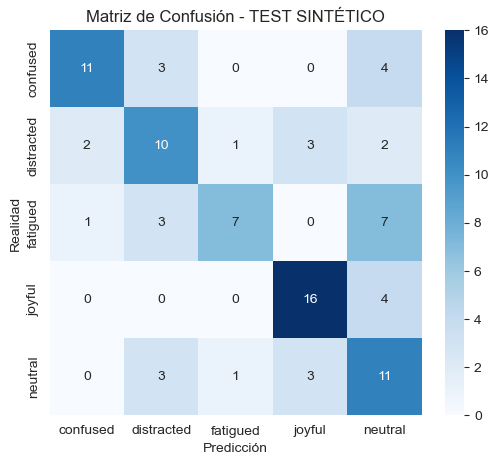

              precision    recall  f1-score   support

    confused       0.79      0.61      0.69        18
  distracted       0.53      0.56      0.54        18
    fatigued       0.78      0.39      0.52        18
      joyful       0.73      0.80      0.76        20
     neutral       0.39      0.61      0.48        18

    accuracy                           0.60        92
   macro avg       0.64      0.59      0.60        92
weighted avg       0.64      0.60      0.60        92


--- Evaluando: DATOS REALES (Tus Fotos) ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step


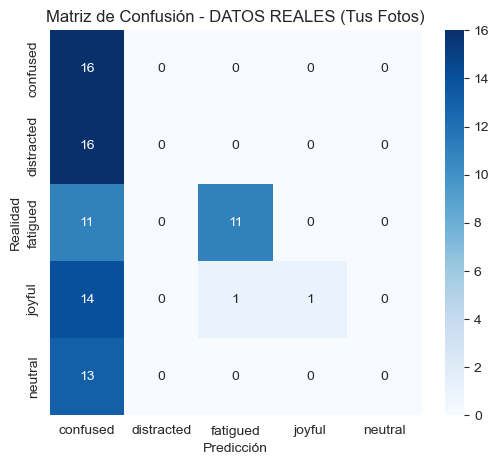

              precision    recall  f1-score   support

    confused       0.23      1.00      0.37        16
  distracted       0.00      0.00      0.00        16
    fatigued       0.92      0.50      0.65        22
      joyful       1.00      0.06      0.12        16
     neutral       0.00      0.00      0.00        13

    accuracy                           0.34        83
   macro avg       0.43      0.31      0.23        83
weighted avg       0.48      0.34      0.27        83



In [99]:

def evaluar_y_graficar(generator, nombre_set):
    print(f"\n--- Evaluando: {nombre_set} ---")
    
    # 1. Obtener Predicciones
    generator.reset()
    predicciones = model_final.predict(generator, verbose=1)
    y_pred = np.argmax(predicciones, axis=1)
    y_true = generator.classes
    
    # Obtener nombres de las clases
    labels = list(generator.class_indices.keys())
    
    # [cite_start]2. Matriz de Confusión [cite: 108]
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Matriz de Confusión - {nombre_set}')
    plt.ylabel('Realidad')
    plt.xlabel('Predicción')
    plt.show()
    
    # [cite_start]3. Reporte de Métricas [cite: 105, 106, 107]
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

# Ejecutar evaluaciones
evaluar_y_graficar(test_generator, "TEST SINTÉTICO")

if 'real_generator' in locals():
    evaluar_y_graficar(real_generator, "DATOS REALES (Tus Fotos)")